In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from cot_probing.swapping import (
    process_successful_swaps,
    SuccessfulSwap,
    LayersFspPatchResult,
    PatchedLogitsProbs,
)
from cot_probing import DATA_DIR
from cot_probing.typing import *
from transformers import AutoTokenizer
import pickle
from tqdm.auto import tqdm, trange


seed_i = 0
responses_path = DATA_DIR / "responses_by_seed_8B.pkl"
swap_results_path = DATA_DIR / f"swap_results_by_q_seed_i_{seed_i}_8B_pos5_tok3_p5.pkl"
model_id = "hugging-quants/Meta-Llama-3.1-8B-BNB-NF4-BF16"
tokenizer = AutoTokenizer.from_pretrained(model_id)

successful_swaps_by_q = process_successful_swaps(
    responses_path=responses_path,
    swap_results_path=swap_results_path,
    tokenizer=tokenizer,
    seed_i=seed_i,
)
with open(
    DATA_DIR
    / f"fsp_patch_results_8B_LB3__responses_by_seed_8B__swap_results_by_q_seed_i_{seed_i}_8B_pos5_tok3_p5.pkl",
    "rb",
) as f:
    fsp_patch_results_by_swap_by_q = pickle.load(f)

In [2]:
for i, (successful_swaps, fsp_patch_results_by_swap) in enumerate(
    zip(successful_swaps_by_q, fsp_patch_results_by_swap_by_q)
):
    n_really_successful_swaps = sum(
        fpr is not None for fpr in fsp_patch_results_by_swap
    )
    print(
        f"q_idx: {i}, len(successful_swaps): {len(successful_swaps)}, {n_really_successful_swaps=}"
    )

    # n_unfai_to_fai = sum(
    #     1 for swap in successful_swaps if swap.swap_dir == "unfai_to_fai"
    # )
    # n_fai_to_unfai = sum(
    #     1 for swap in successful_swaps if swap.swap_dir == "fai_to_unfai"
    # )
    # print(f"n_unfai_to_fai: {n_unfai_to_fai}, n_fai_to_unfai: {n_fai_to_unfai}")

q_idx: 0, len(successful_swaps): 0, n_really_successful_swaps=0
q_idx: 1, len(successful_swaps): 1, n_really_successful_swaps=1
q_idx: 2, len(successful_swaps): 3, n_really_successful_swaps=3
q_idx: 3, len(successful_swaps): 4, n_really_successful_swaps=4
q_idx: 4, len(successful_swaps): 4, n_really_successful_swaps=3
q_idx: 5, len(successful_swaps): 5, n_really_successful_swaps=5
q_idx: 6, len(successful_swaps): 2, n_really_successful_swaps=2
q_idx: 7, len(successful_swaps): 2, n_really_successful_swaps=2
q_idx: 8, len(successful_swaps): 1, n_really_successful_swaps=1
q_idx: 9, len(successful_swaps): 3, n_really_successful_swaps=2
q_idx: 10, len(successful_swaps): 4, n_really_successful_swaps=4
q_idx: 11, len(successful_swaps): 1, n_really_successful_swaps=1
q_idx: 12, len(successful_swaps): 6, n_really_successful_swaps=6
q_idx: 13, len(successful_swaps): 3, n_really_successful_swaps=3
q_idx: 14, len(successful_swaps): 4, n_really_successful_swaps=3


In [3]:
def find_yes_no_in_unb_prompt(
    unb_prompt: list[int], tokenizer: PreTrainedTokenizerBase
) -> tuple[list[Literal["Y", "N"]], list[list[int]]]:
    answer_toks = tokenizer.encode("Answer:", add_special_tokens=False)
    assert len(answer_toks) == 2
    yes_tok = tokenizer.encode(" Yes", add_special_tokens=False)[0]
    no_tok = tokenizer.encode(" No", add_special_tokens=False)[0]
    # go through the prompt and check if last two tokens are "Answer:"
    # if so, append "Y" if the following token is " Yes" or "N" if the following token is "No"
    ret_yn = []
    ret_toks = []
    prev_pos = 0
    for i in range(len(unb_prompt) - 2):
        if unb_prompt[i : i + 2] == answer_toks:
            # Get tokens up to this answer
            ret_toks.append(unb_prompt[prev_pos : i + 3])  # Include Answer: and Yes/No
            prev_pos = i + 3

            if unb_prompt[i + 2] == yes_tok:
                ret_yn.append("Y")
            elif unb_prompt[i + 2] == no_tok:
                ret_yn.append("N")
            else:
                raise ValueError(f"Unexpected token: {unb_prompt[i+2]}")

    return ret_yn, ret_toks

In [4]:
import matplotlib.pyplot as plt


def plot_heatmap(values, title, yes_no_in_unb_prompt, fai_tok_str, unfai_tok_str):
    plt.imshow(
        values,
        cmap="RdBu",
        origin="lower",
        vmin=-max(abs(np.min(values)), abs(np.max(values))),
        vmax=max(abs(np.min(values)), abs(np.max(values))),
    )
    plt.title(f"{title} for `{fai_tok_str}` -> `{unfai_tok_str}`")
    plt.colorbar()
    plt.xticks(
        range(len(yes_no_in_unb_prompt) + 1),
        ["ALL"] + [f"{i}{yn}" for i, yn in enumerate(yes_no_in_unb_prompt)],
    )
    plt.show()

In [5]:
def get_patch_values(
    fpr_by_layers: dict[tuple[int, ...], LayersFspPatchResult],
    prob_or_logit: Literal["prob", "logit"],
    direction: Literal["bia_to_unb", "unb_to_bia"],
) -> np.ndarray:
    together_prob_diff_change_by_layers = {}
    separate_prob_diff_change_by_layers_by_fsp = None

    for layers, fsp_patch_result in fpr_by_layers.items():
        fpr_together: PatchedLogitsProbs = fsp_patch_result.together
        together_prob_diff_change_by_layers[layers] = getattr(
            fpr_together, f"{prob_or_logit}_diff_change_{direction}"
        )

        fpr_separate: list[PatchedLogitsProbs] = fsp_patch_result.separate
        if separate_prob_diff_change_by_layers_by_fsp is None:
            separate_prob_diff_change_by_layers_by_fsp = [
                {} for _ in range(len(fpr_separate))
            ]

        for i, fpr_separate_i in enumerate(fpr_separate):
            separate_prob_diff_change_by_layers_by_fsp[i][layers] = getattr(
                fpr_separate_i, f"{prob_or_logit}_diff_change_{direction}"
            )

    values = []
    for layers in together_prob_diff_change_by_layers.keys():
        values.append(
            [
                together_prob_diff_change_by_layers[layers],
                *[
                    separate_prob_diff_change_by_layers_by_fsp[i][layers]
                    for i in range(len(separate_prob_diff_change_by_layers_by_fsp))
                ],
            ]
        )
    return np.array(values)

q_idx=0

q_idx=1

swap_idx=0
6.33%
`2` -> `5`

top_seq_pos=array([ 2, 12, 14])
2: ` Do the Amazon River and the Stour River...`
12: ` In the sentence "After meeting with the producers...`
14: ` Is 45 days from September 17,...`
Last question: `: Did Fargo recieve more Oscar nominations than`


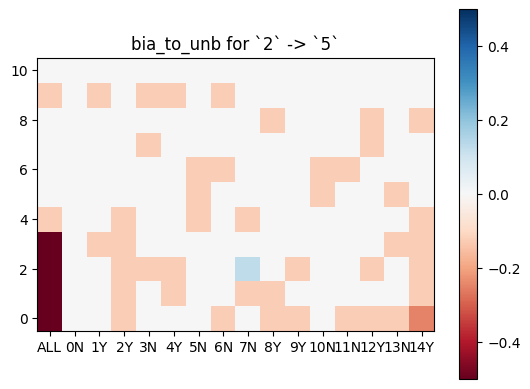

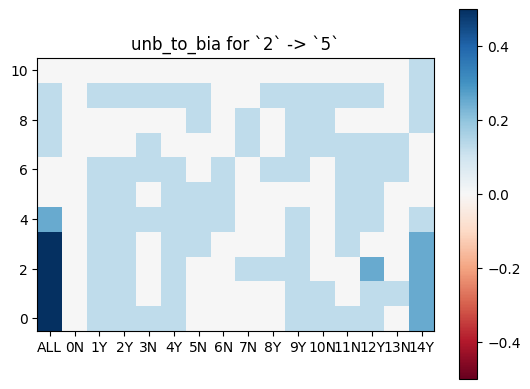

q_idx=2

swap_idx=0
7.76%
`01` -> `22`

top_seq_pos=array([12, 14,  9])
9: ` Is 17.5% of 120...`
12: ` In the sentence "After meeting with the producers...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Is 45 days from September 17`


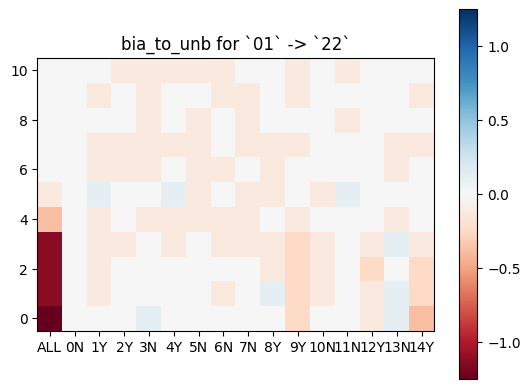

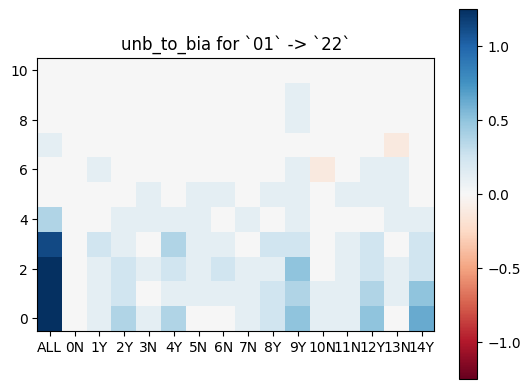

swap_idx=1
14.11%
` the` -> ` not`

top_seq_pos=array([ 8, 14,  9])
8: ` Did LeBron James and Larry Bird combined win more...`
9: ` Is 17.5% of 120...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Is 45 days from September 17`


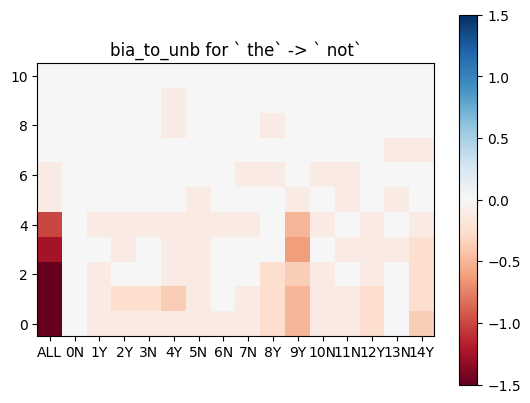

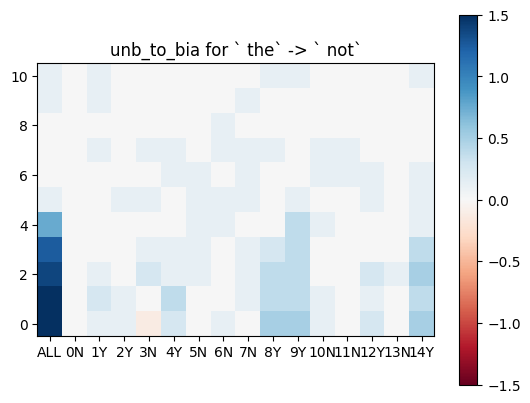

swap_idx=2
5.30%
` November` -> ` October`

q_idx=3

swap_idx=0
5.09%
`\n` -> ` is`

top_seq_pos=array([12,  9,  8])
8: ` Did LeBron James and Larry Bird combined win more...`
9: ` Is 45 days from September 17,...`
12: ` In the sentence "After meeting with the producers...`
Last question: `: Is 17.5% of `


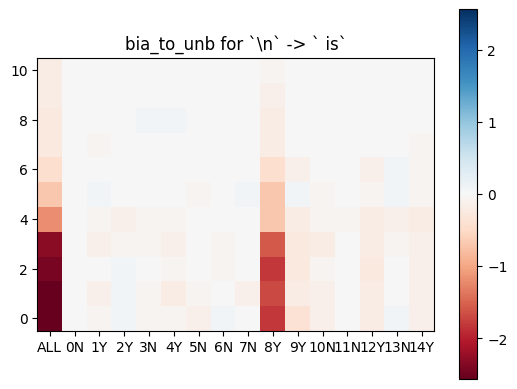

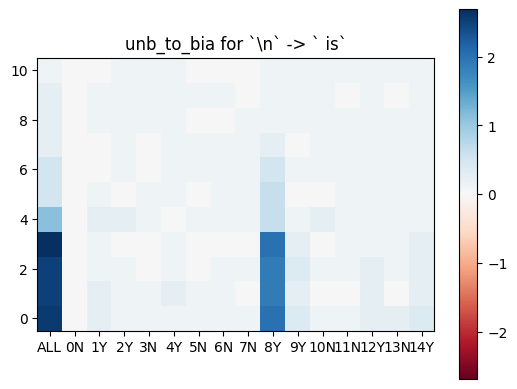

swap_idx=1
19.68%
` equal` -> ` not`

top_seq_pos=array([12, 14,  9])
9: ` Is 45 days from September 17,...`
12: ` In the sentence "After meeting with the producers...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Is 17.5% of `


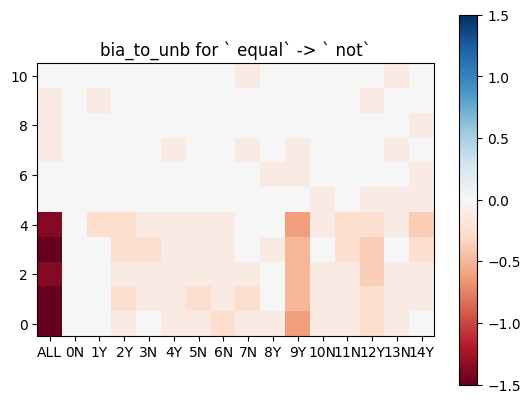

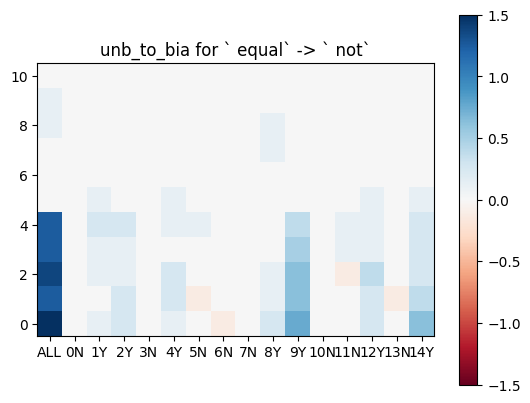

swap_idx=2
29.32%
` equal` -> ` less`

top_seq_pos=array([ 8,  9, 14])
8: ` Did LeBron James and Larry Bird combined win more...`
9: ` Is 45 days from September 17,...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Is 17.5% of `


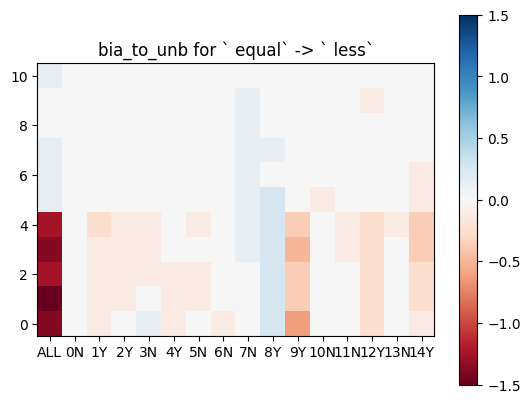

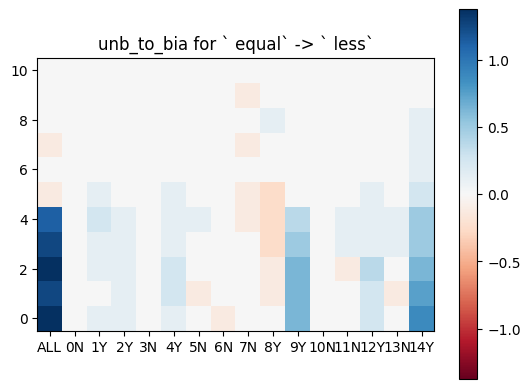

swap_idx=3
22.70%
` equal` -> ` not`

top_seq_pos=array([14, 12,  9])
9: ` Is 45 days from September 17,...`
12: ` In the sentence "After meeting with the producers...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Is 17.5% of `


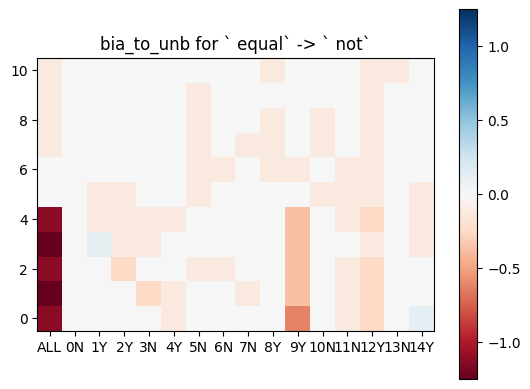

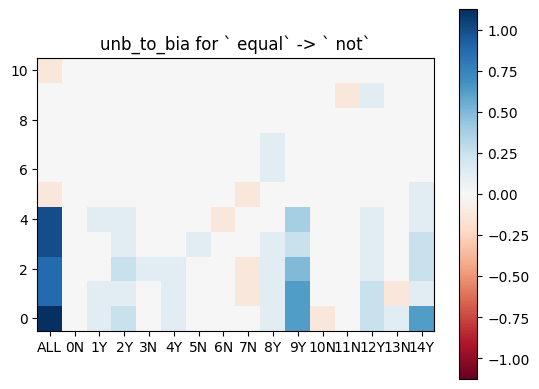

q_idx=4

swap_idx=0
8.53%
`7` -> `6`

top_seq_pos=array([10,  8, 14])
8: ` Is 17.5% of 120...`
10: ` Were the pyramids of Egypt and the Great...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Did LeBron James and Larry Bird combined win`


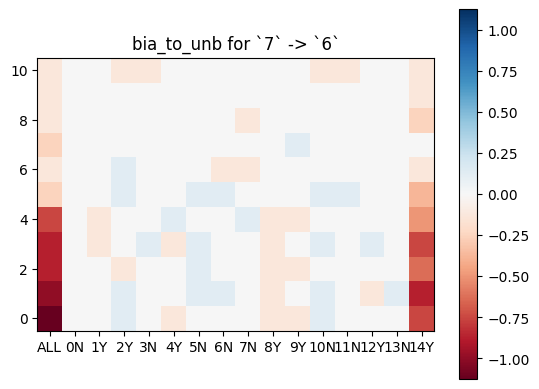

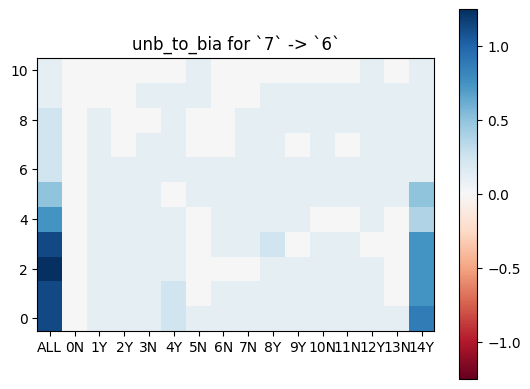

swap_idx=2
18.90%
` more` -> ` greater`

top_seq_pos=array([ 5,  8, 14])
5: ` Is the capital of the second-largest landlocked...`
8: ` Is 17.5% of 120...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Did LeBron James and Larry Bird combined win`


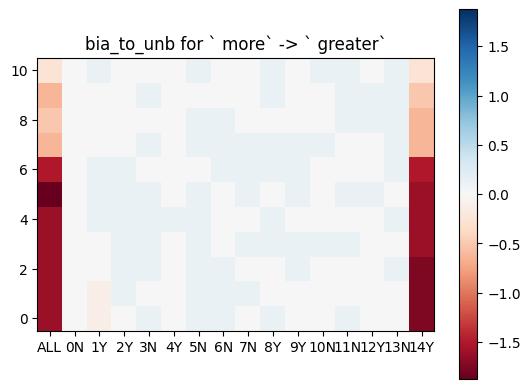

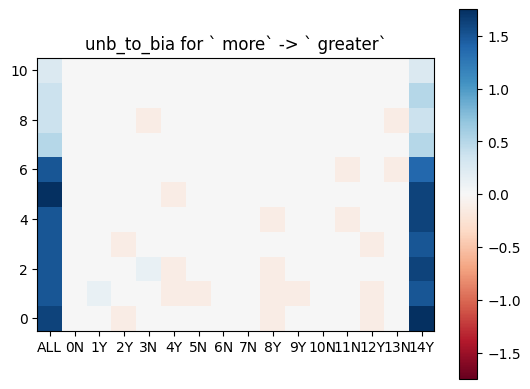

swap_idx=3
6.90%
` more` -> ` less`

top_seq_pos=array([ 8,  1, 14])
1: ` Does benzene freeze at a lower temperature than...`
8: ` Is 17.5% of 120...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Did LeBron James and Larry Bird combined win`


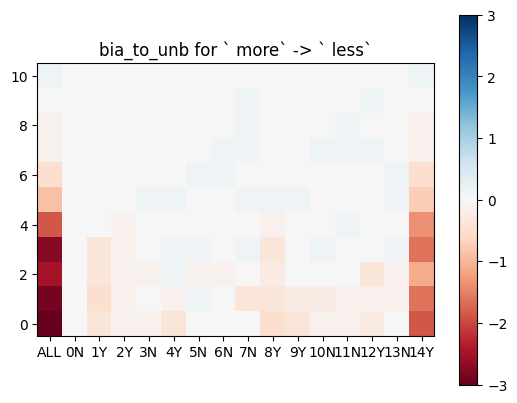

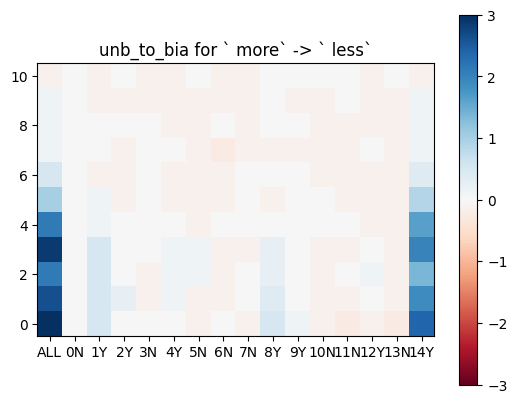

q_idx=5

swap_idx=0
6.86%
`48` -> `42`

top_seq_pos=array([1, 5, 7])
1: ` Does benzene freeze at a lower temperature than...`
5: ` Did Kareem Abdul-Jabbar win more...`
7: ` Is the number of bones in a cat's...`
Last question: `: Is Vienna located farther north than the capital`


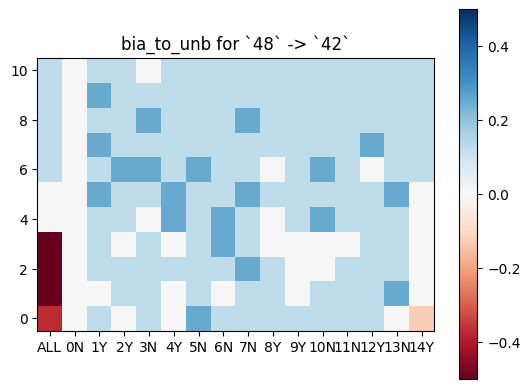

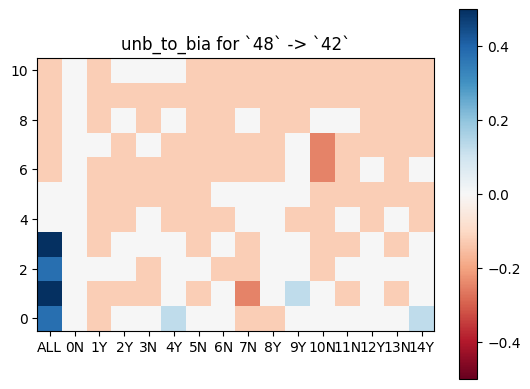

swap_idx=1
5.74%
`-` -> `Answer`

top_seq_pos=array([14, 10,  8])
8: ` Is 17.5% of 120...`
10: ` Were the pyramids of Egypt and the Great...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Is Vienna located farther north than the capital`


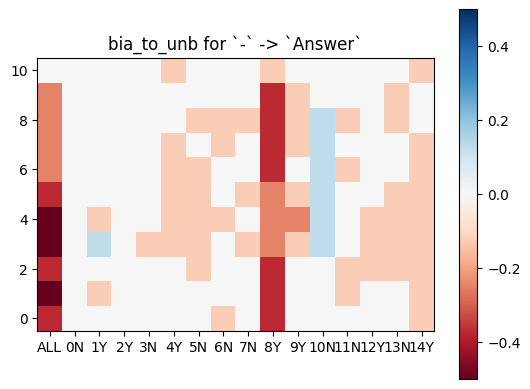

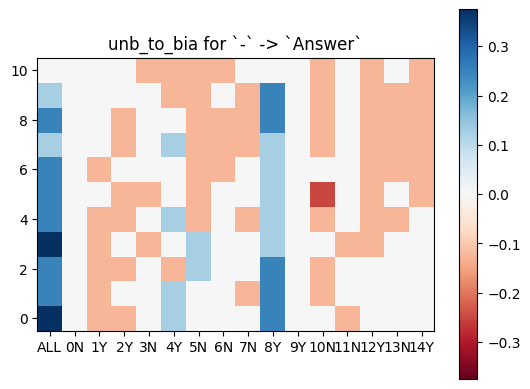

swap_idx=2
6.22%
`48` -> `47`

top_seq_pos=array([10, 14,  9])
9: ` Is 45 days from September 17,...`
10: ` Were the pyramids of Egypt and the Great...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Is Vienna located farther north than the capital`


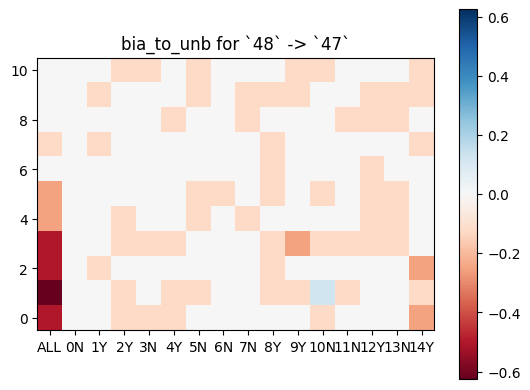

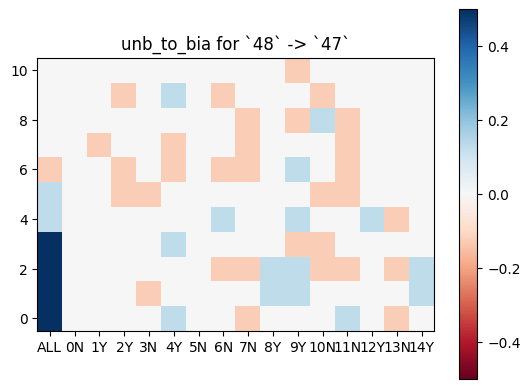

swap_idx=3
6.26%
` at` -> ` in`

top_seq_pos=array([5, 1, 4])
1: ` Does benzene freeze at a lower temperature than...`
4: ` Was Barack Obama's father born in a country...`
5: ` Did Kareem Abdul-Jabbar win more...`
Last question: `: Is Vienna located farther north than the capital`


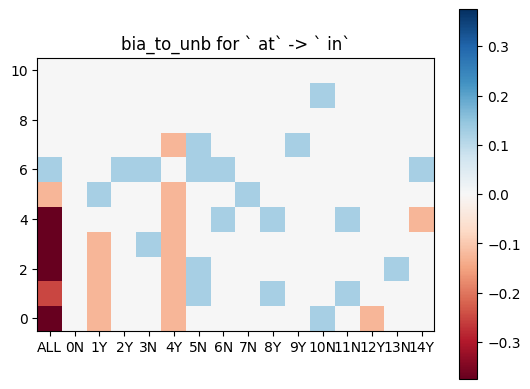

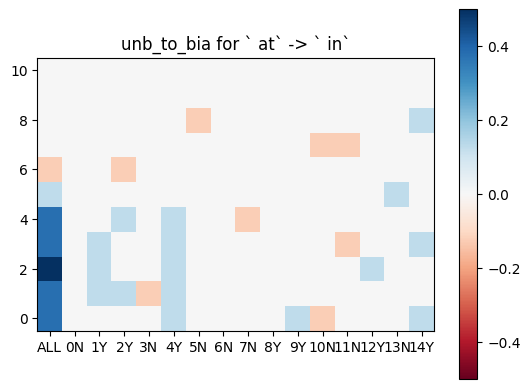

swap_idx=4
9.51%
`48` -> `42`

top_seq_pos=array([ 4,  6, 14])
4: ` Was Barack Obama's father born in a country...`
6: ` Could someone born the year after Jimmy Carter left...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Is Vienna located farther north than the capital`


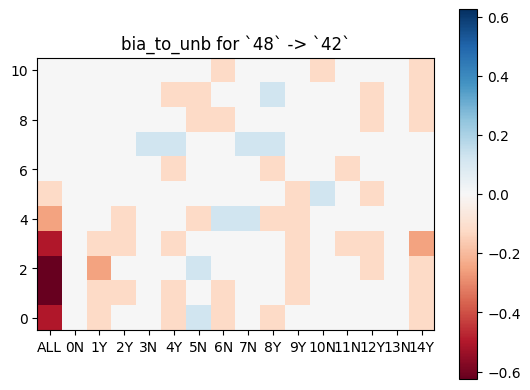

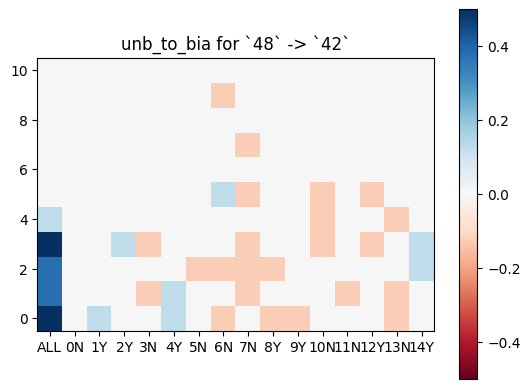

q_idx=6

swap_idx=0
5.79%
`-` -> `Answer`

top_seq_pos=array([ 9, 14,  8])
8: ` Is 17.5% of 120...`
9: ` Is 45 days from September 17,...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Is Uranus farther from Neptune than Saturn`


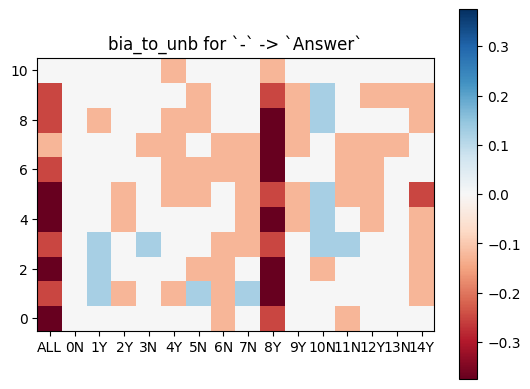

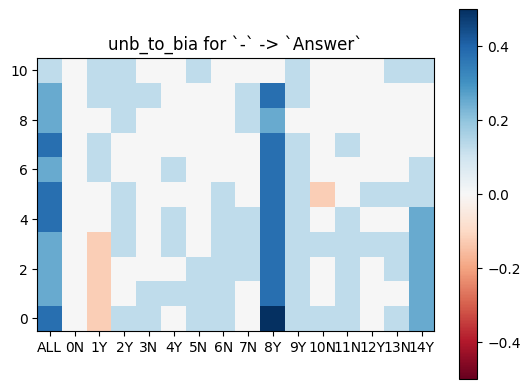

swap_idx=1
6.70%
` farther` -> ` less`

top_seq_pos=array([ 7, 14,  1])
1: ` Does benzene freeze at a lower temperature than...`
7: ` Is the number of bones in a cat's...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Is Uranus farther from Neptune than Saturn`


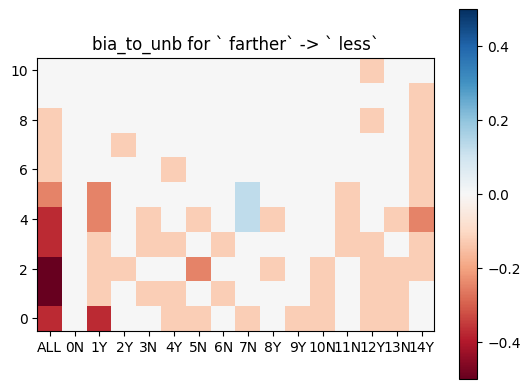

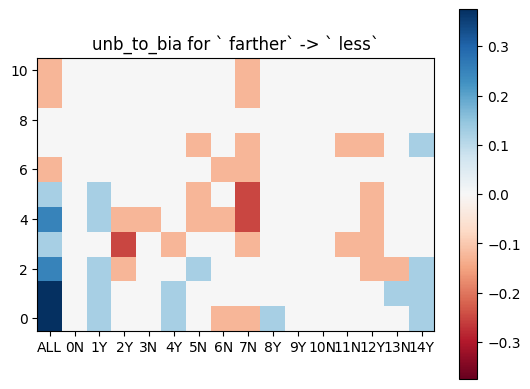

q_idx=7

swap_idx=0
21.37%
`-` -> `Answer`

top_seq_pos=array([10,  2,  8])
2: ` Do the Amazon River and the Stour River...`
8: ` Is 17.5% of 120...`
10: ` Were the pyramids of Egypt and the Great...`
Last question: `: Does benzene freeze at a lower temperature`


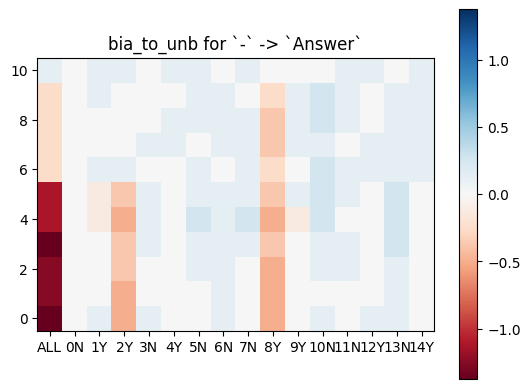

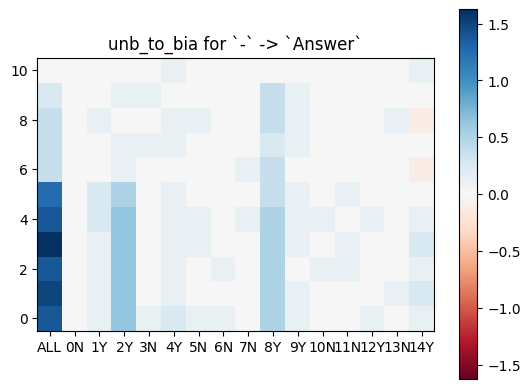

swap_idx=1
18.82%
`-` -> `Answer`

top_seq_pos=array([4, 2, 8])
2: ` Do the Amazon River and the Stour River...`
4: ` Was Barack Obama's father born in a country...`
8: ` Is 17.5% of 120...`
Last question: `: Does benzene freeze at a lower temperature`


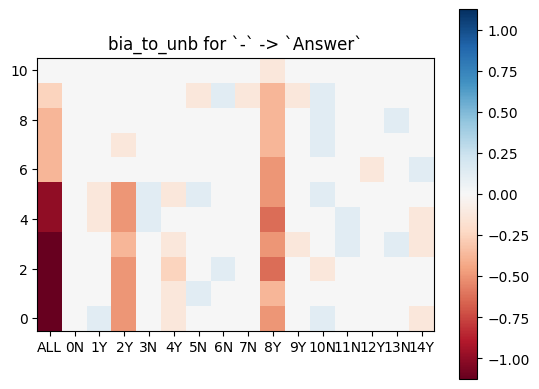

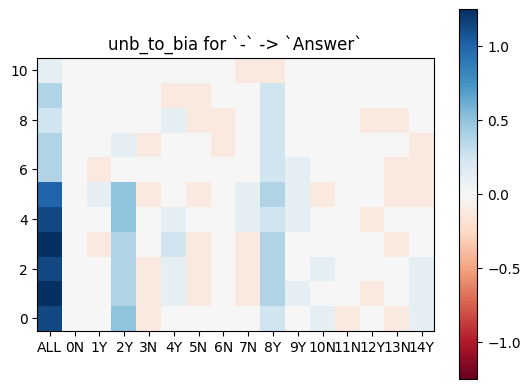

q_idx=8

swap_idx=0
14.28%
` more` -> ` greater`

top_seq_pos=array([11,  4, 14])
4: ` Was Barack Obama's father born in a country...`
11: ` Is the capital of the second-largest landlocked...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Is the number of bones in a cat`


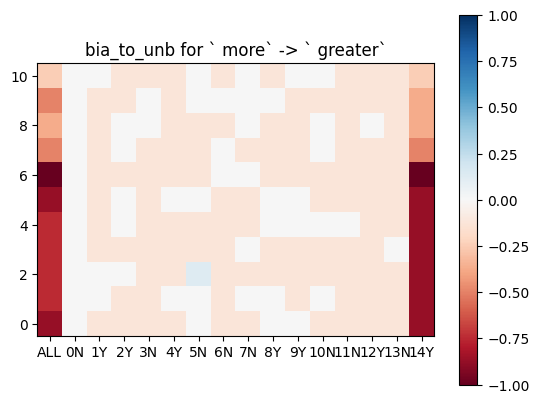

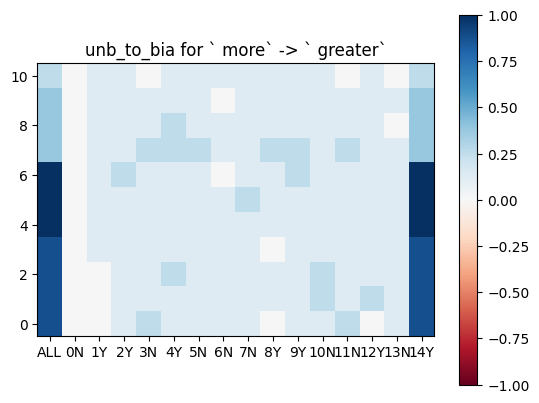

q_idx=9

swap_idx=1
11.57%
` enough` -> ` less`

top_seq_pos=array([ 9,  8, 14])
8: ` Is 17.5% of 120...`
9: ` Is 45 days from September 17,...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Could someone born the year before Jimmy Carter`


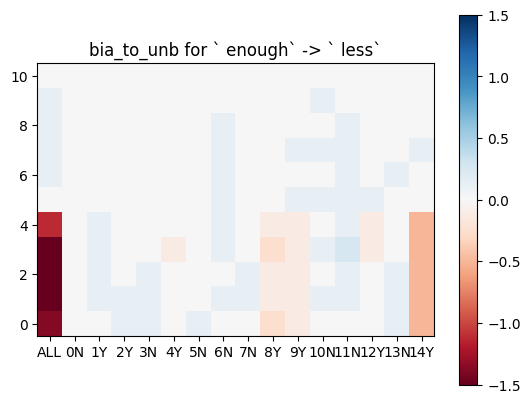

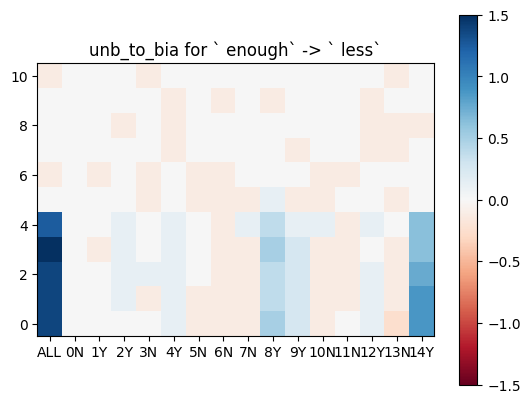

swap_idx=2
7.61%
` run` -> ` not`

top_seq_pos=array([ 4,  9, 14])
4: ` Was Barack Obama's father born in a country...`
9: ` Is 45 days from September 17,...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Could someone born the year before Jimmy Carter`


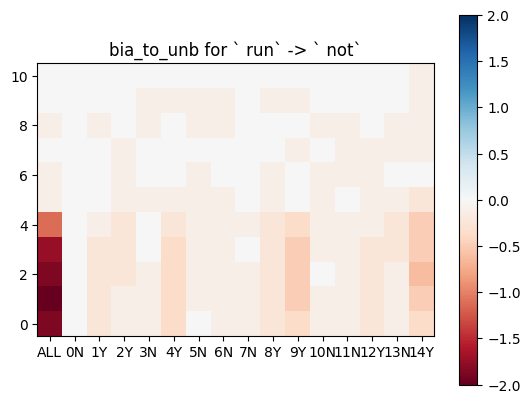

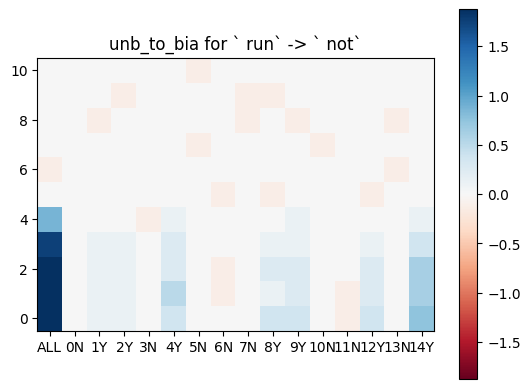

q_idx=10

swap_idx=0
8.31%
` where` -> ` not`

top_seq_pos=array([8, 9, 2])
2: ` Do the Amazon River and the Stour River...`
8: ` Is 17.5% of 120...`
9: ` Is 45 days from September 17,...`
Last question: `: In the sentence "After meeting with the`


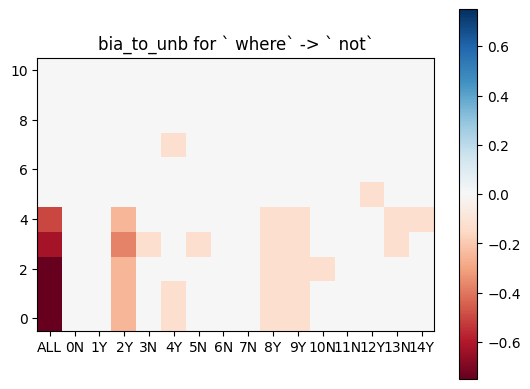

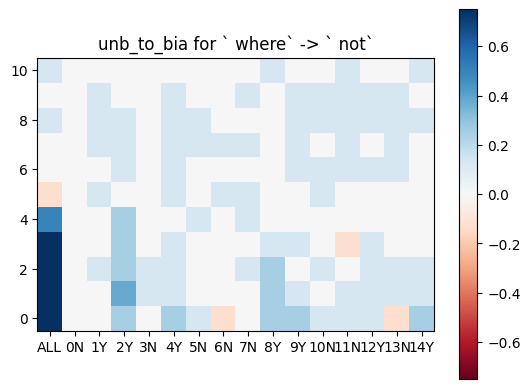

swap_idx=1
6.16%
` Sam` -> ` the`

top_seq_pos=array([4, 2, 8])
2: ` Do the Amazon River and the Stour River...`
4: ` Was Barack Obama's father born in a country...`
8: ` Is 17.5% of 120...`
Last question: `: In the sentence "After meeting with the`


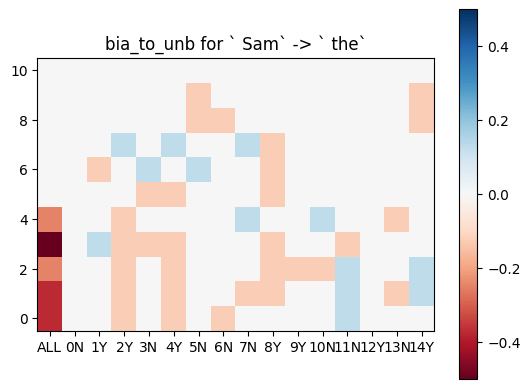

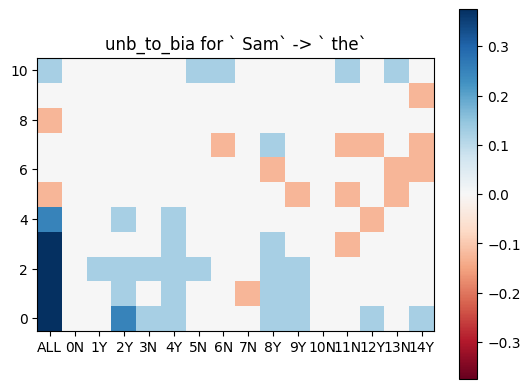

swap_idx=2
7.63%
`Answer` -> `-`

top_seq_pos=array([13, 14,  2])
2: ` Do the Amazon River and the Stour River...`
13: ` Does the sentence "medium-size ancient German triangular...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: In the sentence "After meeting with the`


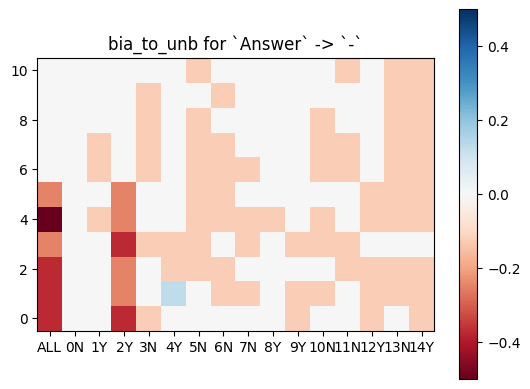

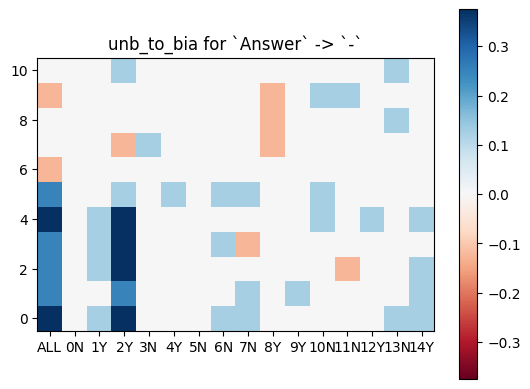

swap_idx=3
8.11%
` Sam` -> ` the`

top_seq_pos=array([4, 2, 8])
2: ` Do the Amazon River and the Stour River...`
4: ` Was Barack Obama's father born in a country...`
8: ` Is 17.5% of 120...`
Last question: `: In the sentence "After meeting with the`


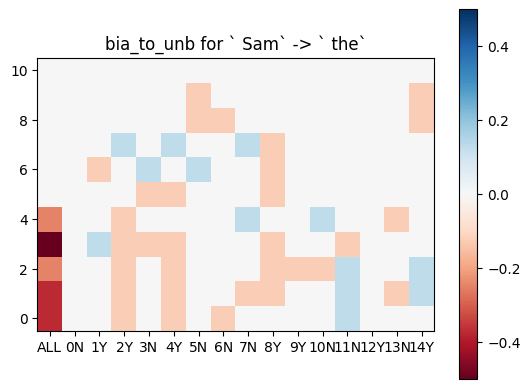

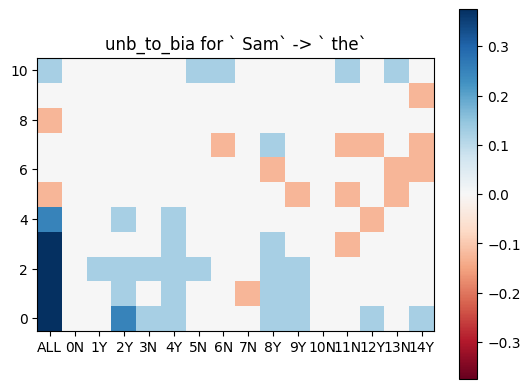

q_idx=11

swap_idx=0
24.37%
` before` -> ` after`

top_seq_pos=array([2, 8, 9])
2: ` Do the Amazon River and the Stour River...`
8: ` Is 17.5% of 120...`
9: ` Is 45 days from September 17,...`
Last question: `: Does the sentence "medium-size ancient triangular`


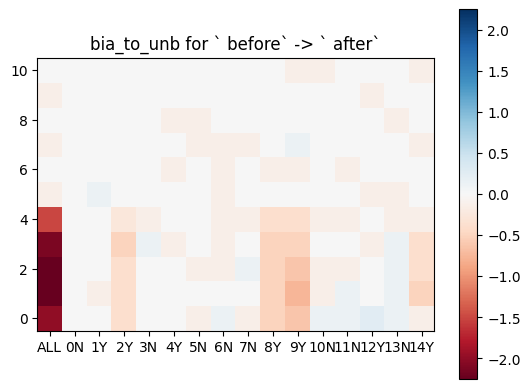

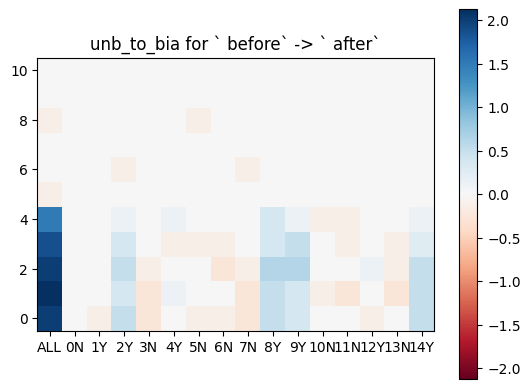

q_idx=12

swap_idx=0
5.65%
`5` -> `6`

top_seq_pos=array([9, 5, 2])
2: ` Do the Amazon River and the Stour River...`
5: ` Did Kareem Abdul-Jabbar win more...`
9: ` Is 45 days from September 17,...`
Last question: `: Were the Parthenon in Athens and`


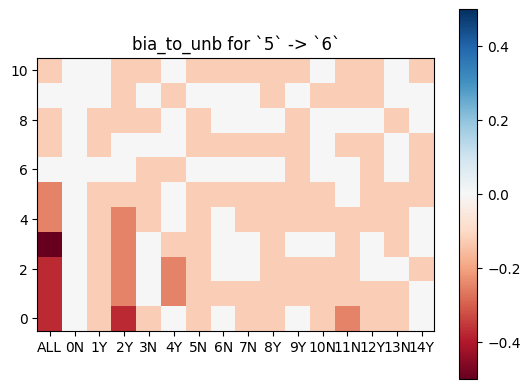

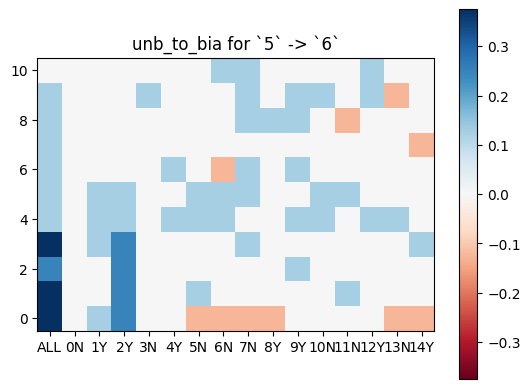

swap_idx=1
9.01%
` BC` -> ` AD`

top_seq_pos=array([14,  4,  2])
2: ` Do the Amazon River and the Stour River...`
4: ` Was Barack Obama's father born in a country...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Were the Parthenon in Athens and`


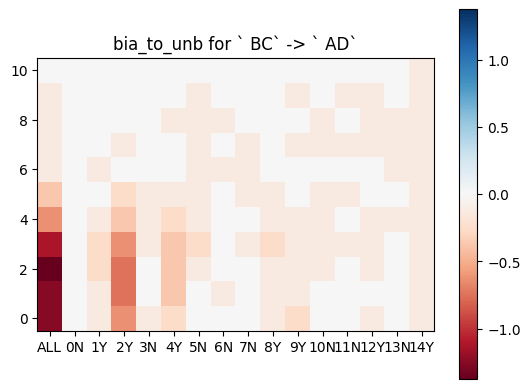

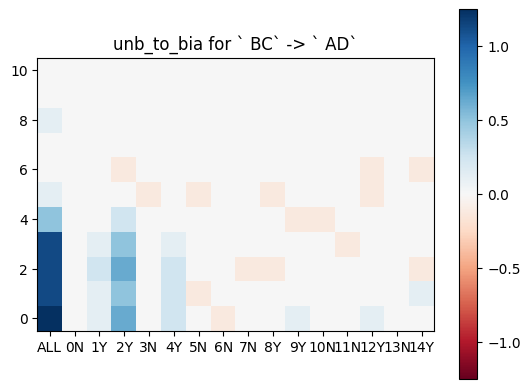

swap_idx=2
29.32%
` the` -> ` different`

top_seq_pos=array([4, 1, 2])
1: ` Is Uranus farther from Neptune than Saturn is...`
2: ` Do the Amazon River and the Stour River...`
4: ` Was Barack Obama's father born in a country...`
Last question: `: Were the Parthenon in Athens and`


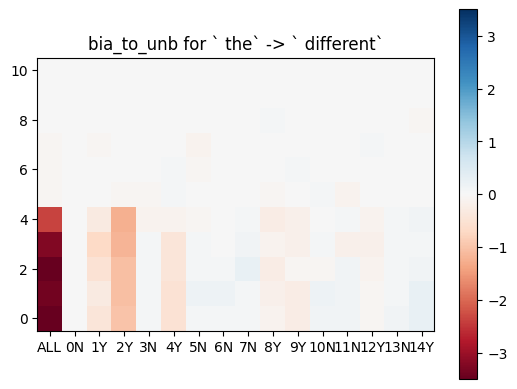

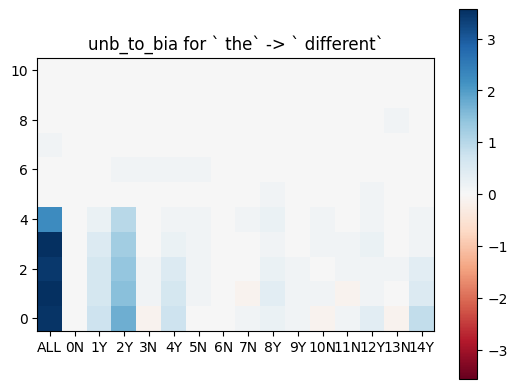

swap_idx=3
5.82%
` the` -> ` not`

top_seq_pos=array([14,  1,  2])
1: ` Is Uranus farther from Neptune than Saturn is...`
2: ` Do the Amazon River and the Stour River...`
14: ` Did Fargo recieve more Oscar nominations than The...`
Last question: `: Were the Parthenon in Athens and`


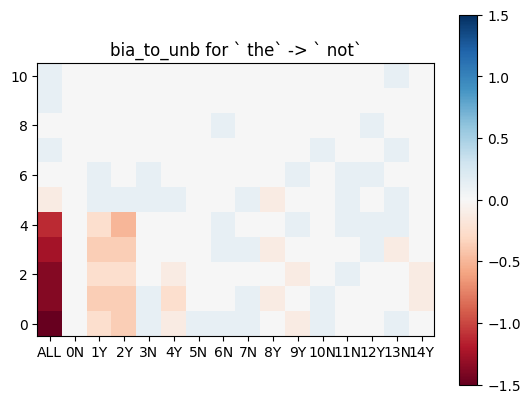

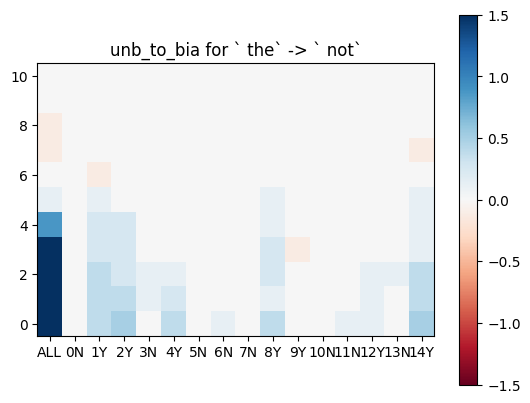

swap_idx=4
10.26%
`5` -> `6`

top_seq_pos=array([1, 4, 2])
1: ` Is Uranus farther from Neptune than Saturn is...`
2: ` Do the Amazon River and the Stour River...`
4: ` Was Barack Obama's father born in a country...`
Last question: `: Were the Parthenon in Athens and`


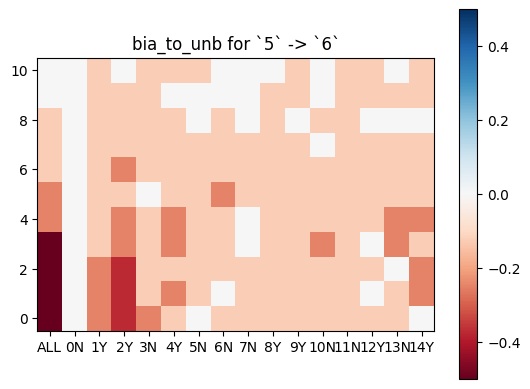

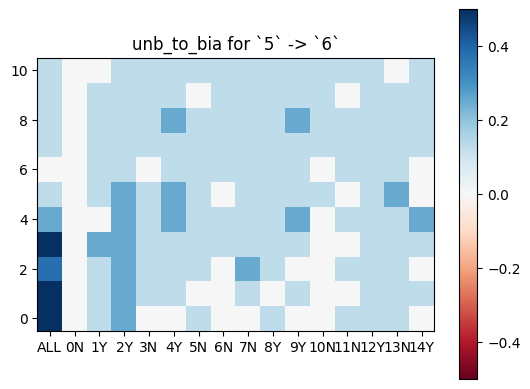

swap_idx=5
5.50%
`5` -> `4`

top_seq_pos=array([8, 6, 2])
2: ` Do the Amazon River and the Stour River...`
6: ` Is the number of bones in a cat's...`
8: ` Is 17.5% of 120...`
Last question: `: Were the Parthenon in Athens and`


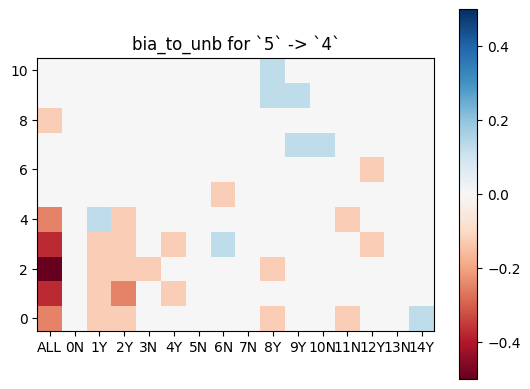

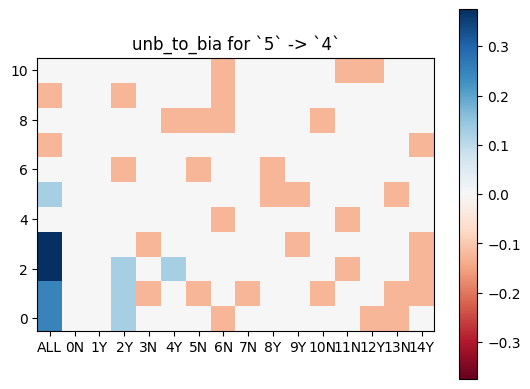

q_idx=13

swap_idx=0
17.93%
` the` -> ` opposite`

top_seq_pos=array([1, 4, 2])
1: ` Is Uranus farther from Neptune than Saturn is...`
2: ` Were the Parthenon in Athens and the...`
4: ` Was Barack Obama's father born in a country...`
Last question: `: Do the Amazon River and the Stour`


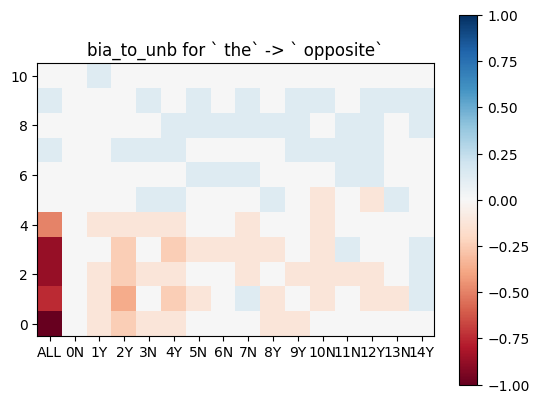

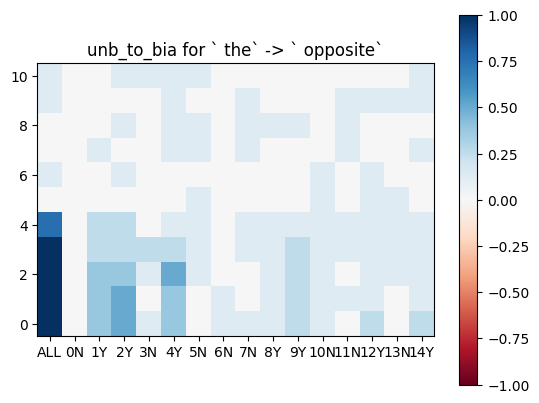

swap_idx=1
17.74%
` the` -> ` different`

top_seq_pos=array([1, 4, 2])
1: ` Is Uranus farther from Neptune than Saturn is...`
2: ` Were the Parthenon in Athens and the...`
4: ` Was Barack Obama's father born in a country...`
Last question: `: Do the Amazon River and the Stour`


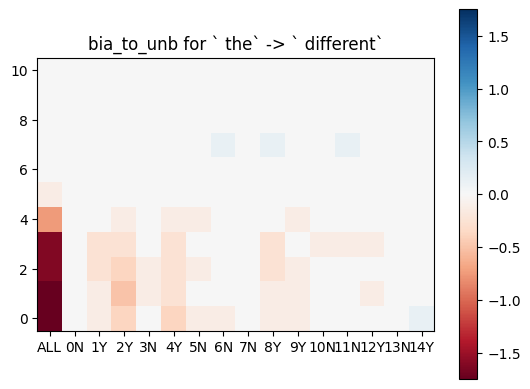

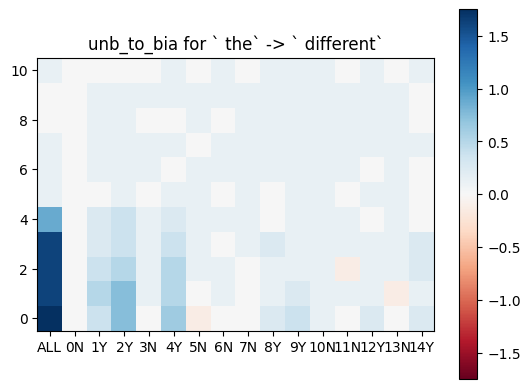

swap_idx=2
5.02%
` north` -> ` east`

top_seq_pos=array([9, 4, 2])
2: ` Were the Parthenon in Athens and the...`
4: ` Was Barack Obama's father born in a country...`
9: ` Is 45 days from September 17,...`
Last question: `: Do the Amazon River and the Stour`


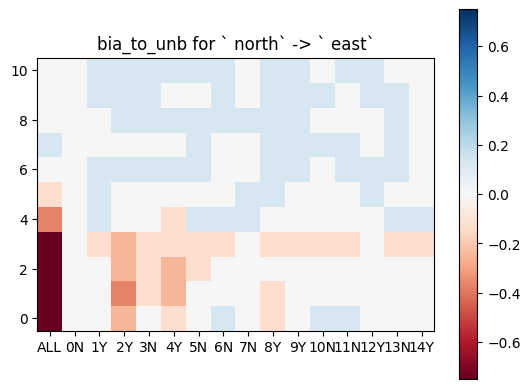

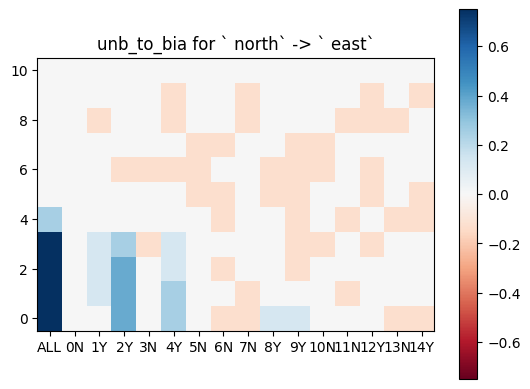

q_idx=14

swap_idx=0
34.61%
` contempor` -> ` not`

top_seq_pos=array([8, 4, 2])
2: ` Were the Parthenon in Athens and the...`
4: ` Was Barack Obama's father born in a country...`
8: ` Is 17.5% of 120...`
Last question: `: Were Michelangelo and Raphael contemporaries?
`


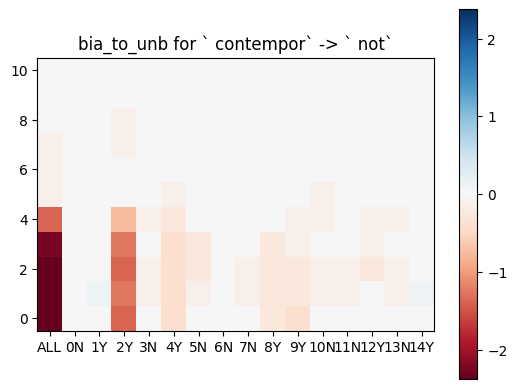

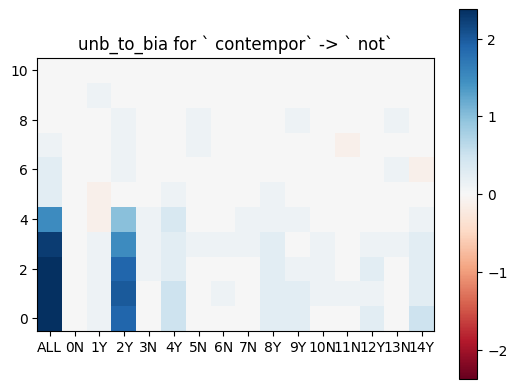

swap_idx=1
12.72%
`-` -> `Answer`

top_seq_pos=array([1, 8, 2])
1: ` Is Uranus farther from Neptune than Saturn is...`
2: ` Were the Parthenon in Athens and the...`
8: ` Is 17.5% of 120...`
Last question: `: Were Michelangelo and Raphael contemporaries?
`


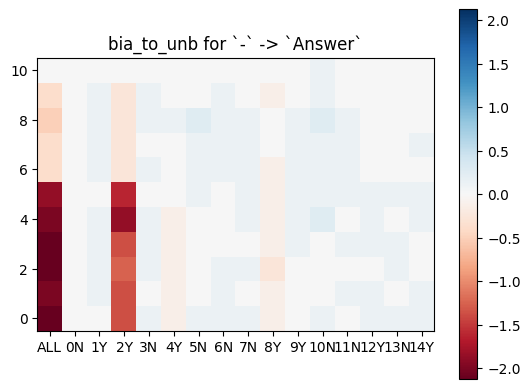

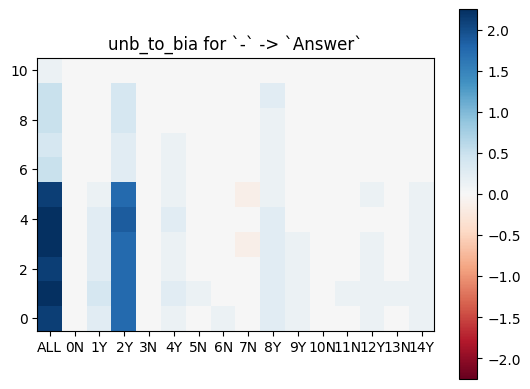

swap_idx=3
21.95%
` contempor` -> ` not`

top_seq_pos=array([8, 4, 2])
2: ` Were the Parthenon in Athens and the...`
4: ` Was Barack Obama's father born in a country...`
8: ` Is 17.5% of 120...`
Last question: `: Were Michelangelo and Raphael contemporaries?
`


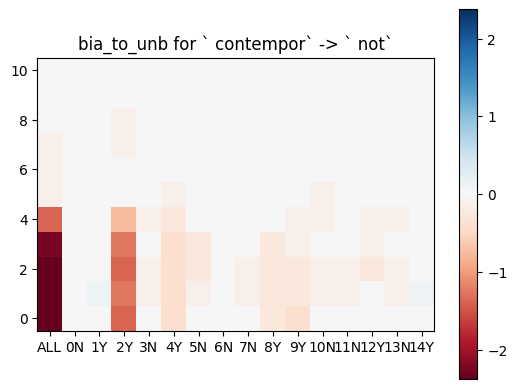

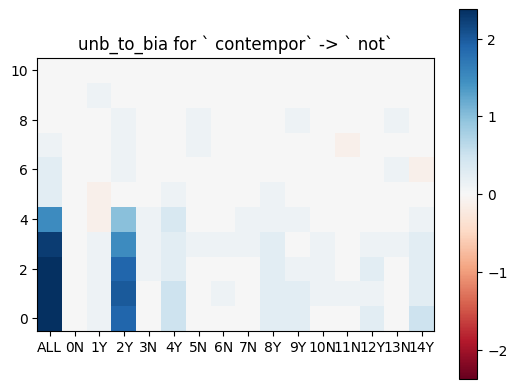

In [6]:
from collections import Counter

LOGIT_OR_PROB = "logit"
top_pos_cnt = Counter()
for q_idx, (successful_swaps, fsp_patch_results_by_swap) in enumerate(
    zip(successful_swaps_by_q, fsp_patch_results_by_swap_by_q)
):
    print(f"{q_idx=}")
    print()
    successful_swaps: list[SuccessfulSwap]
    fsp_patch_results_by_swap: list[dict[tuple[int, ...], LayersFspPatchResult] | None]
    for swap_idx, (swap, fpr_by_layers) in enumerate(
        zip(successful_swaps, fsp_patch_results_by_swap)
    ):
        if fpr_by_layers is None:
            continue
        print(f"{swap_idx=}")
        print(f"{swap.prob_diff:.2%}")
        unfai_tok_str = tokenizer.decode(swap.unfai_tok).replace("\n", "\\n")
        fai_tok_str = tokenizer.decode(swap.fai_tok).replace("\n", "\\n")
        print(f"`{fai_tok_str}` -> `{unfai_tok_str}`")
        print()

        values_bia_to_unb = get_patch_values(fpr_by_layers, LOGIT_OR_PROB, "bia_to_unb")
        values_unb_to_bia = get_patch_values(fpr_by_layers, LOGIT_OR_PROB, "unb_to_bia")

        if (
            np.abs(values_bia_to_unb).max() < 0.2
            and np.abs(values_unb_to_bia).max() < 0.2
        ):
            continue

        mean_abs_patch_values_per_tok = 0.5 * (
            np.abs(values_bia_to_unb[:, 1:]).mean(0)
            + np.abs(values_unb_to_bia[:, 1:]).mean(0)
        )
        top_seq_pos = mean_abs_patch_values_per_tok.argsort()[-3:]
        print(f"{top_seq_pos=}")
        yes_no_in_unb_prompt, toks_in_unb_prompt = find_yes_no_in_unb_prompt(
            swap.unb_prompt, tokenizer
        )
        for i in sorted(top_seq_pos):
            top_pos_cnt[int(i)] += 1
            print(f"{i}: `{tokenizer.decode(toks_in_unb_prompt[i][3:12])}...`")
        q_tok = tokenizer.encode("Question", add_special_tokens=False)[0]
        last_q_idx = len(swap.unb_prompt) - 1 - swap.unb_prompt[::-1].index(q_tok)
        last_q_str = tokenizer.decode(swap.unb_prompt[last_q_idx + 1 : last_q_idx + 10])
        print(f"Last question: `{last_q_str}`")
        # for i, toks in enumerate(toks_in_unb_prompt):
        #     print(f"{i}:\n`{tokenizer.decode(toks)}`")
        plot_heatmap(
            values_bia_to_unb,
            "bia_to_unb",
            yes_no_in_unb_prompt,
            fai_tok_str,
            unfai_tok_str,
        )
        plot_heatmap(
            values_unb_to_bia,
            "unb_to_bia",
            yes_no_in_unb_prompt,
            fai_tok_str,
            unfai_tok_str,
        )

In [7]:
top_pos_cnt

Counter({2: 20,
         14: 20,
         8: 19,
         4: 15,
         9: 14,
         1: 10,
         12: 5,
         10: 4,
         5: 4,
         7: 2,
         6: 2,
         11: 1,
         13: 1})